## Part 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import griddata

In [3]:
import os
fig_dir = 'figs'
table_dir = 'tables'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
if not os.path.exists(table_dir):
    os.makedirs(table_dir)

In [4]:
mi_Xe = 131.293*1.66*10**-27
elem_charge = 1.6*10**-19
r0=1

In [5]:
# Angle phi is given in radians
def beam2(phi, a0=0.0014895, a1=103.12, a2=60.169):
    return a0 + a1 / (a2 + (phi*180/np.pi)**2)

def beam3(phi, b1=1.9, b2=5, b3=0.12):
    try:
        epsilon = 1e-3  # Small value to avoid division by zero
        phi_adjusted = np.where(phi <= 1e-3, epsilon, phi)
        exponent = -b2 * phi**2 / (b3 + phi_adjusted**1.6)
        # Cap the exponent to prevent overflow in the exp function
        exponent = np.clip(exponent, -20, 20)
        vals = b1 * np.exp(exponent)
        return np.real(vals)  # Return the real part in case of complex numbers
    except Exception as e:
        return np.zeros_like(phi)  # Return an array of zeros of the same shape

def beam4(phi, I0=0.195, beta=50.231, r0=1):
    return (I0*(beta+1)) / (2*np.pi*r0**2) * np.cos(phi)**beta

def beam1(r, phi, beamf=beam2, r0=1):
    return beamf(phi) * (r/r0)**-2

def delta(phi):
    return (beam2(phi)-beam3(phi)) / beam2(phi)

def energy_dist(phi, b0=-185.59, b1=2.898*10**6, b2=6839.0, toJ=False):
    if toJ:
        return (b0 + b1 / (b2 + (phi*180/np.pi)**2)) * 1.602*10**-19
    else:
        return b0 + b1 / (b2 + (phi*180/np.pi)**2) # energy in eV

def vel_dist(phi, mi=mi_Xe, ed=energy_dist):
    # return np.sqrt(2*ed(phi)*1.602*10**-19 / mi) # velocity in m/s
    return np.sqrt(2*ed(phi) / mi) # velocity in m/s

def calcAngle(vec1, vec2, deg=False):
    dot_prod = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if deg:
        return np.arccos(dot_prod / (norm1 * norm2))
    else:
        return np.arccos(dot_prod / (norm1 * norm2))
                

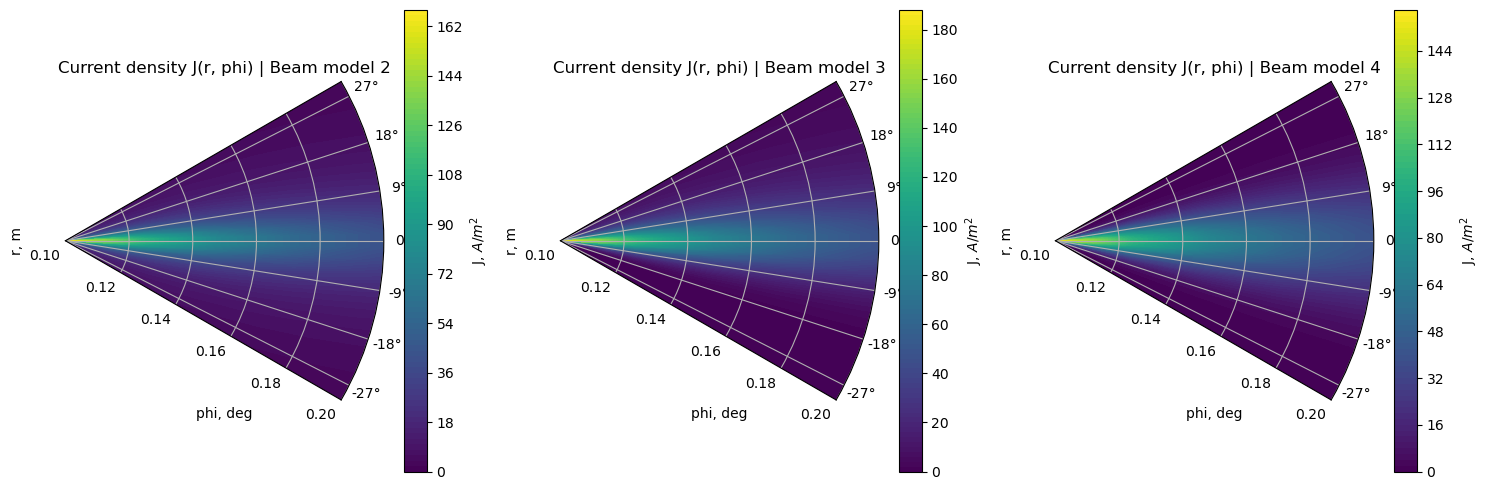

In [92]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(polar=True), figsize=(15, 5))

n_points = 80
lvls = n_points
phi_vl = np.pi/6
phi_start = -phi_vl
phi_end = phi_vl
r_start = 0.1
r_end = 2

rmax = 0.2
thetamin = phi_start * 180/np.pi
thetamax = phi_end * 180/np.pi


phi_range = np.linspace(phi_start, phi_end, n_points)
r_range = np.linspace(r_start, r_end, n_points)

phi_range = np.linspace(-np.pi/2, np.pi/2, n_points)
for i, beam_model in enumerate([beam2, beam3, beam4]):
    R, PHI = np.meshgrid(r_range, phi_range)
    J = beam1(R, PHI, beamf=beam_model)

    ax = axes[i]
    contour = ax.contourf(PHI, R, J, 100)
    ax.set_title(f'Current density J(r, phi) | Beam model {i+2}')
    ax.set_xlabel('phi, deg')
    ax.set_ylabel('r, m')
    ax.set_rmax(rmax)
    ax.set_thetamin(thetamin)
    ax.set_thetamax(thetamax)
    # Add a colorbar to the current subplot
    fig.colorbar(contour, ax=ax, orientation='vertical', label=r'J, $A/m^2$')

plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, 'current_density_J_polar_dist.png'), dpi=300)
plt.show()

### Part 3

In [7]:
def qi(r, phi, theta, beamf=beam4, energyd=energy_dist):
    return beam1(r, phi, beamf, r0=1) * energyd(phi, toJ=False) * np.cos(theta) # * 10 # from mA/cm2 to A/m2
def qs(Qs, As):
    return Qs * As

def teq(r, phi, theta, Qs, As, epsilon, sigma=5.670 * 1e-8, beamf=beam4, energyd=energy_dist):
        return (
             (qs(Qs, As) + qi(r, phi, theta, beamf, energyd)) / epsilon * sigma
        )**0.25

In [8]:
Qs = 1360.8 # W/m2
sigma_b = 5.670 * 1e-8 # W/(m^2*K^4)
As_lst = np.array([0.8, 0.85, 0.6, 0.55, 0.15, 0.25, 0.05, 0.3])
epsilon_lst = np.array([0.15, 0.9, 0.45, 0.9, 0.05, 0.25, 0.85, 0.9])
theta_lsp = np.linspace(0, np.pi/2, len(epsilon_lst))

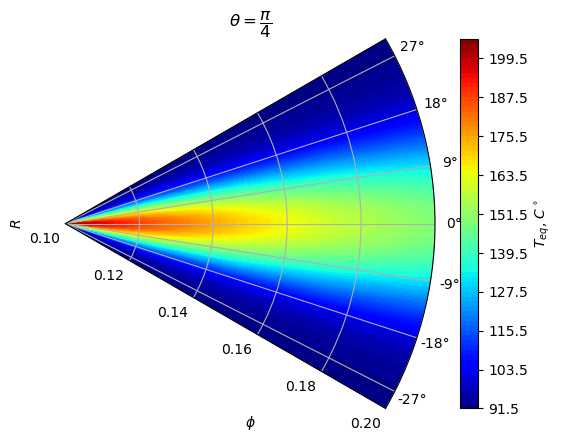

In [100]:
R, PHI = np.meshgrid(r_range, phi_range)
Teq = teq(R, PHI, np.pi/4, Qs, As_lst[1], epsilon_lst[1], sigma=sigma_b) * 1e3

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
contour = ax.contourf(PHI, R, Teq, levels=lvls, cmap='jet')
fig.colorbar(contour, orientation='vertical', label=r'$T_{eq}$, $C^\circ$')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$R$')
plt.title(r"$\theta=\dfrac{\pi}{4}$")
ax.set_rmax(rmax)
ax.set_thetamin(thetamin)
ax.set_thetamax(thetamax)
# plt.savefig(os.path.join(fig_dir,  'temp_angle_theta_dist.png'), dpi=300)
plt.show()

## Part 4

In [10]:
a_sp = 5   # m
b_sp = 2.5 # m
z_sp = 2.5 # m
hd = 2.5   # m
zd = 1     # m

alpha_d = 0 / 180 * np.pi # in radians
origin = np.array([hd, 0, zd])
sh_vec = np.array([np.cos(alpha_d), 0, np.sin(alpha_d)])

sp_z = np.linspace(0, a_sp, n_points) + z_sp
sp_y = np.linspace(-b_sp/2, b_sp/2, n_points)
spZ, spY = np.meshgrid(sp_z, sp_y)

In [11]:
theta_ar = np.zeros_like(spZ)
phi_ar = np.zeros_like(spZ)
for i in range(n_points):
    for j in range(n_points):
        point = np.array([0, spY[i, j], spZ[i, j]])
        radius_vector = origin - point
        normal_vector = np.array([1, 0, 0])
        theta_ar[i,j] = calcAngle(radius_vector, normal_vector, deg=True)
        phi_ar[i,j] = calcAngle(radius_vector, sh_vec, deg=True)

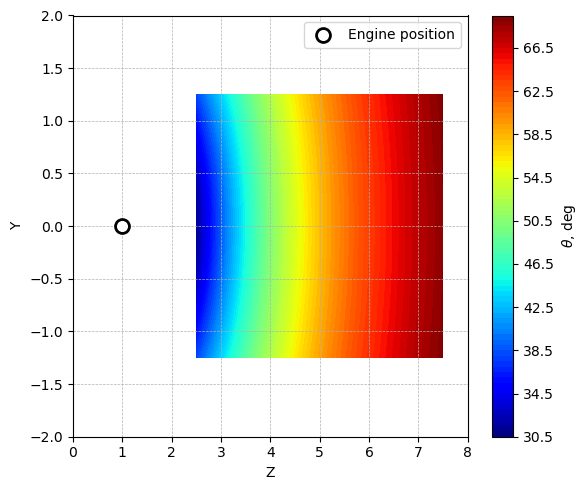

In [98]:
# Plot the contour
plt.figure(figsize=(6, 5))
plt.scatter(origin[2], origin[1], c='white',\
            s=100, zorder=10, alpha=1, label='Engine position', edgecolors='black', linewidths=2)
plt.contourf(spZ, spY, theta_ar*180/np.pi, levels=lvls, cmap='jet')
plt.xlim(0, 8)
plt.ylim(-2, 2)
plt.xlabel("Z")
plt.ylabel("Y")
plt.colorbar(label=r"$\theta$, deg")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, 'current_angle_thete_dist.png'), dpi=300)
plt.show()

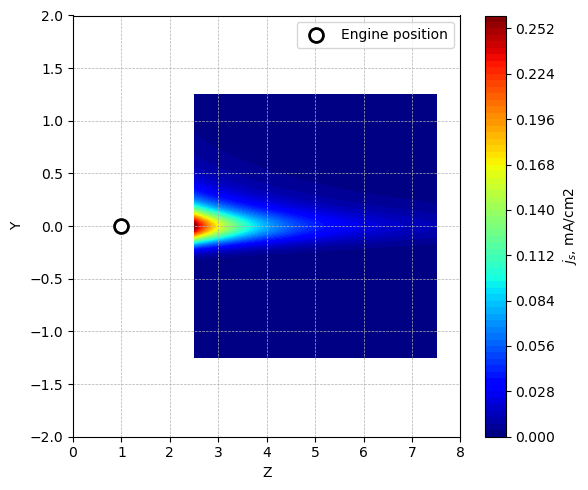

In [99]:
J = beam1(spZ, spY, beamf=beam3, r0=1)
# Plot the contour
plt.figure(figsize=(6, 5))
plt.scatter(origin[2], origin[1], c='white',\
            s=100, zorder=10, alpha=1, label='Engine position', edgecolors='black', linewidths=2)
plt.contourf(spZ, spY, abs(J*np.cos(theta_ar)), levels=lvls, cmap='jet')
plt.xlim(0, 8)
plt.ylim(-2, 2)
plt.xlabel("Z")
plt.ylabel("Y")
plt.colorbar(label=r"$j_s$, mA/cm2")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, 'current_J_thete_dist.png'), dpi=300)
plt.show()

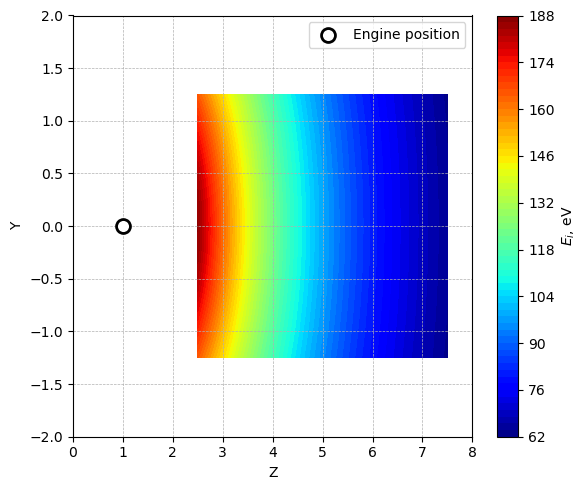

In [97]:
plt.figure(figsize=(6, 5))
plt.scatter(origin[2], origin[1], c='white',\
            s=100, zorder=10, alpha=1, label='Engine position', edgecolors='black', linewidths=2)
plt.contourf(spZ, spY, energy_dist(theta_ar), levels=lvls, cmap='jet')
plt.xlim(0, 8)
plt.ylim(-2, 2)
plt.xlabel("Z")
plt.ylabel("Y")
plt.colorbar(label=r"$E_i$, eV")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, 'energy_dist.png'), dpi=300)
plt.show()

## Erosion calculations

In [16]:
data_path = "./digit_functions"
fe_data = pd.read_csv(data_path + "/fE_data.csv")
fe_data = fe_data.apply(pd.to_numeric, errors='coerce')

fe_data.drop(index=0, inplace=True)
data_0_deg = fe_data[['0_deg', 'Unnamed: 1']].dropna().rename(columns={'0_deg': 'X', 'Unnamed: 1': 'Y'})
data_7_5_deg = fe_data[['7.5_deg', 'Unnamed: 3']].dropna().rename(columns={'7.5_deg': 'X', 'Unnamed: 3': 'Y'})
data_22_5_deg = fe_data[['22.5_deg', 'Unnamed: 5']].dropna().rename(columns={'22.5_deg': 'X', 'Unnamed: 5': 'Y'})


In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import sklearn

# KNN regression function
def knn_regression(data, num=n_points, n_neighbors=5):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(data[['X']], data['Y'])
    x_new = np.linspace(data['X'].min(), data['X'].max(), num)
    x_new_df = pd.DataFrame(x_new, columns=['X'])  # Ensure x_new is a DataFrame
    y_new = knn.predict(x_new_df)
    rmse = np.sqrt(mean_squared_error(data['Y'], knn.predict(data[['X']])))
    range_y = data['Y'].max() - data['Y'].min()
    rmse_percentage = (rmse / range_y) * 100
    return x_new, y_new, rmse_percentage


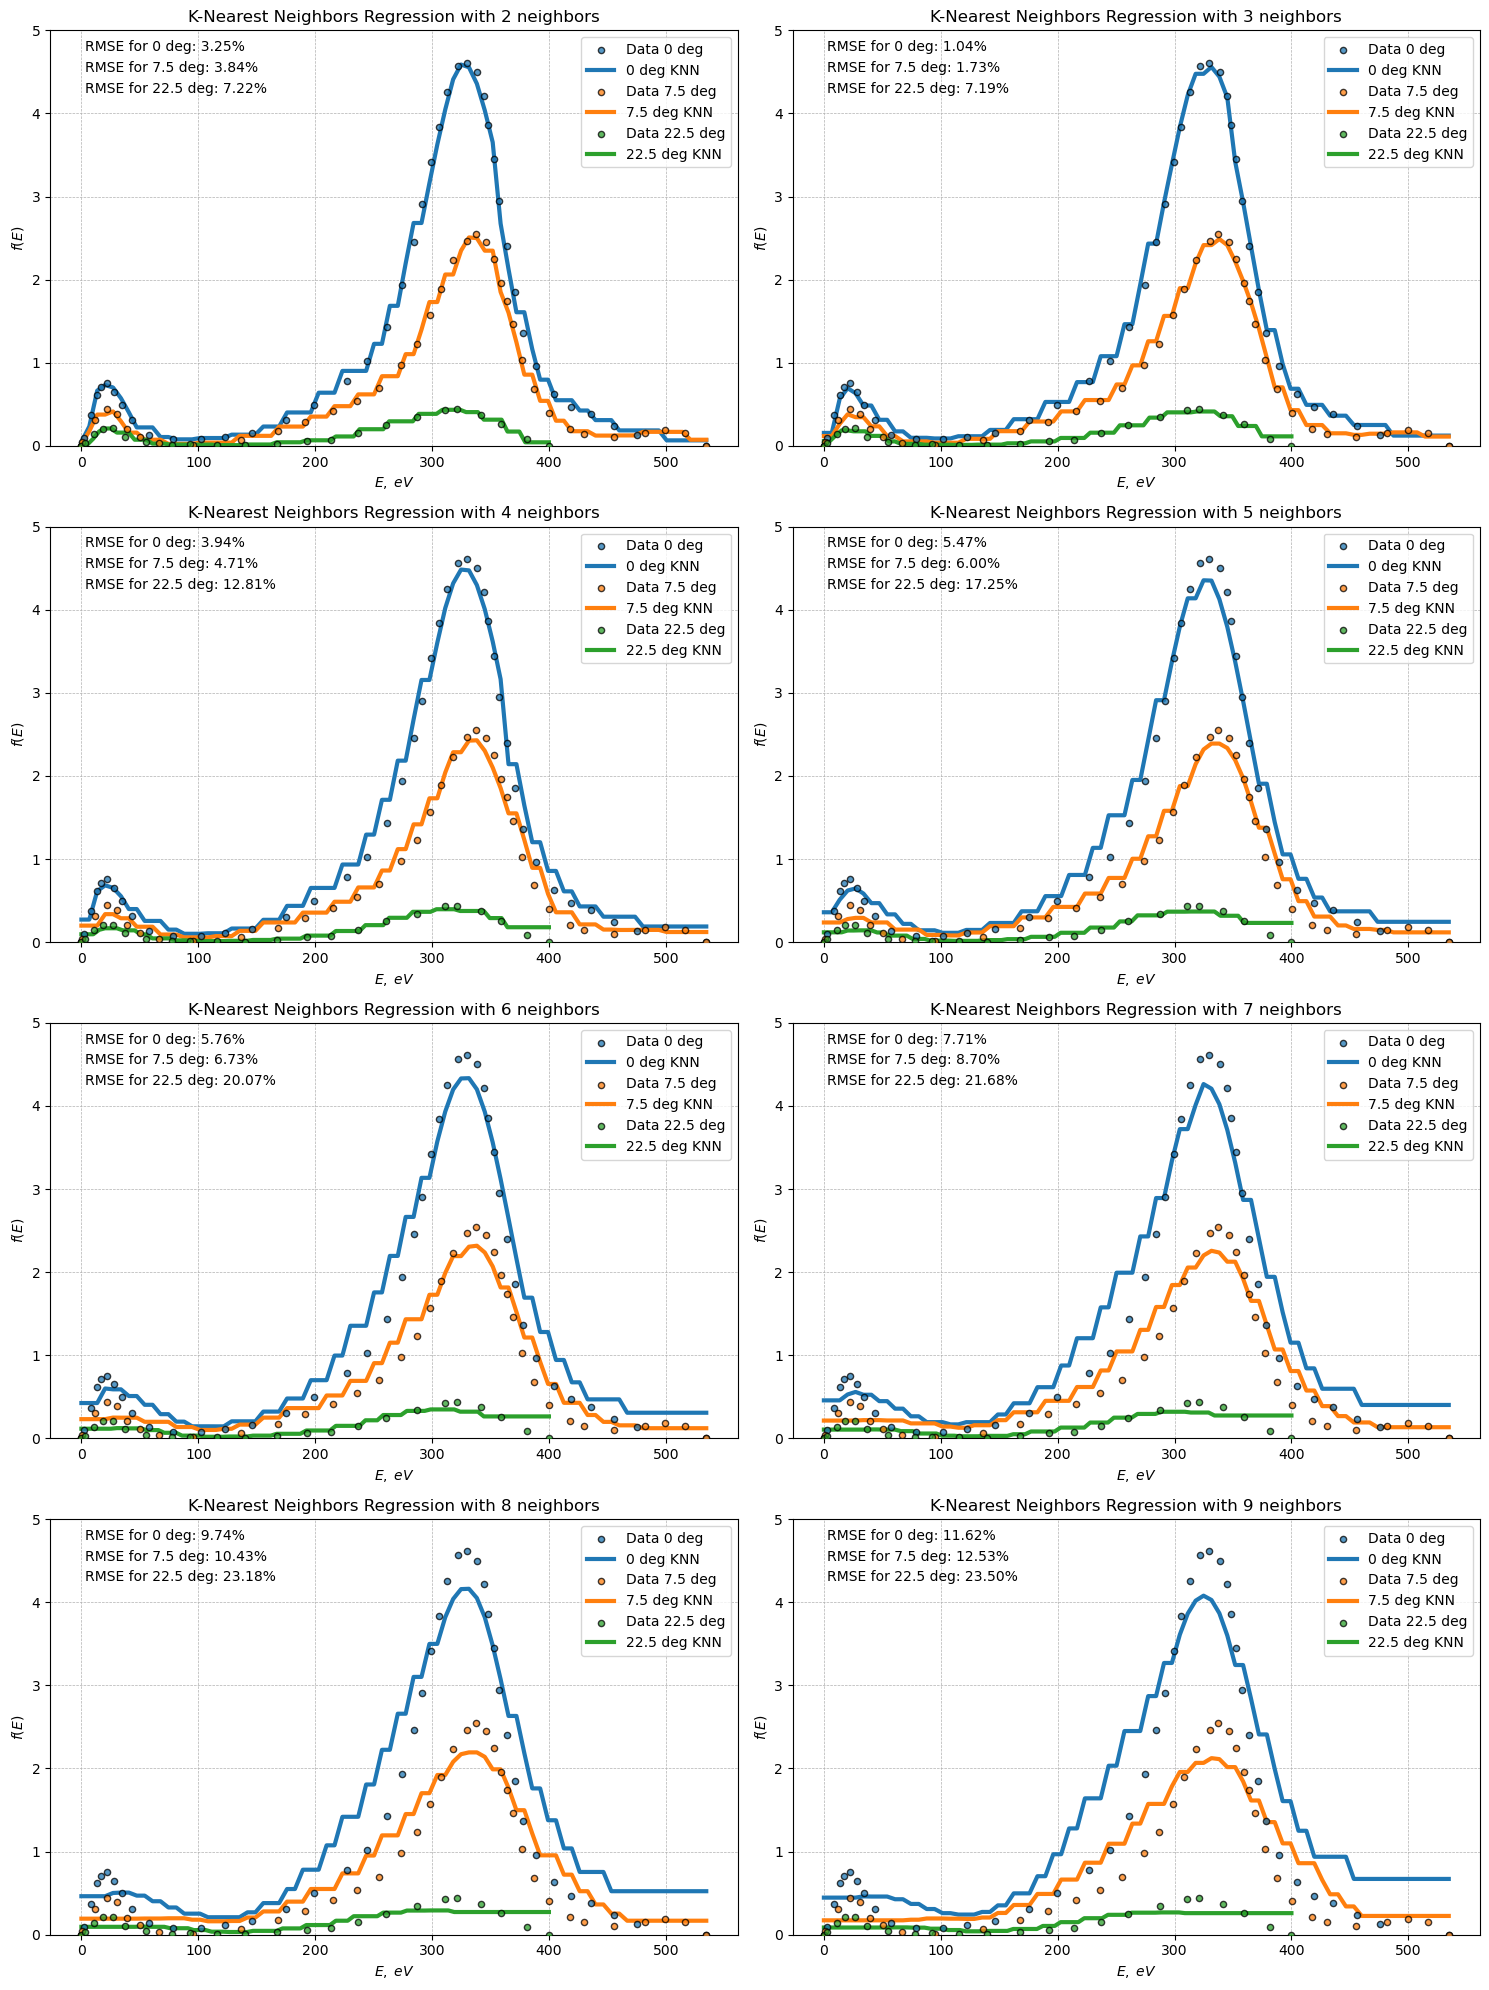

In [18]:
# Plot and save interpolated data with error metrics
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for idx, n_neighbors in enumerate(range(2, 10)):
    ax = axes[idx]
    rmse_list = []
    for data, name in zip([data_0_deg, data_7_5_deg, data_22_5_deg], ['0 deg', '7.5 deg', '22.5 deg']):
        x_new, y_new, rmse_percentage = knn_regression(data, n_points, n_neighbors)
        rmse_list.append((name, rmse_percentage))
        ax.scatter(data['X'], data['Y'], s=20, zorder=10, alpha=0.75, edgecolors='black', linewidths=1, label=f"Data {name}")
        ax.plot(x_new, y_new, linewidth=3, label=f"{name} KNN")
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f"K-Nearest Neighbors Regression with {n_neighbors} neighbors")
    ax.set_ylim(0, 5)
    ax.legend()
    ax.set_xlabel(r"$E,\;eV$")
    ax.set_ylabel(r"$f(E)$")
    for name, rmse_percentage in rmse_list:
        ax.text(0.05, 0.95 - rmse_list.index((name, rmse_percentage)) * 0.05, f"RMSE for {name}: {rmse_percentage:.2f}%", transform=ax.transAxes)
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir,  f"selected_knn_{n_neighbors}.png"), dpi=300)
plt.show()

In [19]:
# Select functions KNN with n = 3 for future usage
selected_n_neighbors = 3
selected_results = {}
for data, name in zip([data_0_deg, data_7_5_deg, data_22_5_deg], ['0 deg', '7.5 deg', '22.5 deg']):
    x_new, y_new, rmse_percentage = knn_regression(data, n_points, selected_n_neighbors)
    selected_results[name] = pd.DataFrame({'X': x_new, 'Y': y_new, 'RMSE_Percentage': rmse_percentage})

# Access the selected results if needed
for name, df in selected_results.items():
    print(f"{name} DataFrame with KNN (n={selected_n_neighbors}):")
    print(df.head())

# Save the selected results to CSV files if needed
for name, df in selected_results.items():
    df.to_csv(f"{data_path}/selected_knn_{name.replace(' ', '_')}.csv", index=False)

0 deg DataFrame with KNN (n=3):
           X         Y  RMSE_Percentage
0   0.000000  0.156980         1.044001
1   6.767190  0.156980         1.044001
2  13.534381  0.567680         1.044001
3  20.301571  0.695408         1.044001
4  27.068761  0.634841         1.044001
7.5 deg DataFrame with KNN (n=3):
           X         Y  RMSE_Percentage
0   0.000000  0.118606         1.726289
1   6.767190  0.118606         1.726289
2  13.534381  0.266349         1.726289
3  20.301571  0.381145         1.726289
4  27.068761  0.346190         1.726289
22.5 deg DataFrame with KNN (n=3):
           X         Y  RMSE_Percentage
0   0.000000  0.058318         7.191645
1   5.063291  0.058318         7.191645
2  10.126582  0.127557         7.191645
3  15.189873  0.187614         7.191645
4  20.253165  0.187614         7.191645


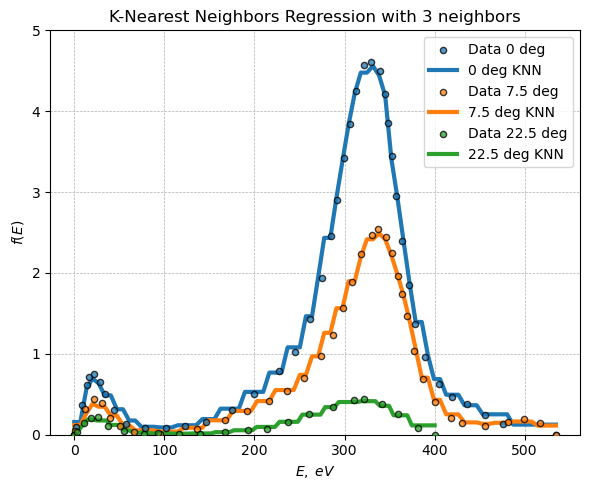

In [20]:
plt.figure(figsize=(6,  5))

for data, name in zip([data_0_deg, data_7_5_deg, data_22_5_deg], ['0 deg', '7.5 deg', '22.5 deg']):
    x_new, y_new, rmse_percentage = knn_regression(data, n_points, selected_n_neighbors)
    rmse_list.append((name, rmse_percentage))
    plt.scatter(data['X'], data['Y'], s=20, zorder=10, alpha=0.75, edgecolors='black', linewidths=1, label=f"Data {name}")
    plt.plot(x_new, y_new, linewidth=3, label=f"{name} KNN")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"K-Nearest Neighbors Regression with {selected_n_neighbors} neighbors")
plt.ylim(0, 5)
plt.legend()
plt.xlabel(r"$E,\;eV$")
plt.ylabel(r"$f(E)$")
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir,  f"selected_knn_{selected_n_neighbors}.png"), dpi=300)
plt.show()

## Creating $f(E,\varphi)$

In [28]:
# Load the data
data_path = "./digit_functions"
fe_data = pd.read_csv(data_path + "/fE_data.csv")

# Drop the first row as it contains header information repeated as strings
fe_data.drop(index=0, inplace=True)

# Convert all columns to numeric, coerce errors to NaN
fe_data = fe_data.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (optional, if you want to remove incomplete rows)
fe_data.fillna(0, inplace=True)

# Print column names to debug
print("Column names after loading and processing:")
print(fe_data.columns)

# Separate the data for each curve
data_0_deg = fe_data.iloc[:, [0, 1]].rename(columns={fe_data.columns[0]: 'E', fe_data.columns[1]: 'f(E)'})
data_7_5_deg = fe_data.iloc[:, [2, 3]].rename(columns={fe_data.columns[2]: 'E', fe_data.columns[3]: 'f(E)'})
data_22_5_deg = fe_data.iloc[:, [4, 5]].rename(columns={fe_data.columns[4]: 'E', fe_data.columns[5]: 'f(E)'})

Column names after loading and processing:
Index(['0_deg', 'Unnamed: 1', '7.5_deg', 'Unnamed: 3', '22.5_deg',
       'Unnamed: 5'],
      dtype='object')


In [29]:
# Add the phi column
data_0_deg['phi'] = 0
data_7_5_deg['phi'] = 7.5
data_22_5_deg['phi'] = 22.5

# Combine the data
combined_data = pd.concat([data_0_deg, data_7_5_deg, data_22_5_deg])

combined_data.head()

,E,f(E),phi
1,0.000000,0.000000,0.0
2,2.294455,0.098567,0.0
3,8.413002,0.372372,0.0
4,13.766730,0.618801,0.0
5,16.826004,0.711868,0.0


In [30]:
# Create a grid for interpolation
E_values = np.linspace(combined_data['E'].min(), combined_data['E'].max(), n_points)
phi_values = np.linspace(combined_data['phi'].min(), combined_data['phi'].max(), n_points)
E_grid, phi_grid = np.meshgrid(E_values, phi_values)

# Interpolate the data
f_values = griddata(
    (combined_data['E'], combined_data['phi']), 
    combined_data['f(E)'], 
    (E_grid, phi_grid), 
    method='linear'
)

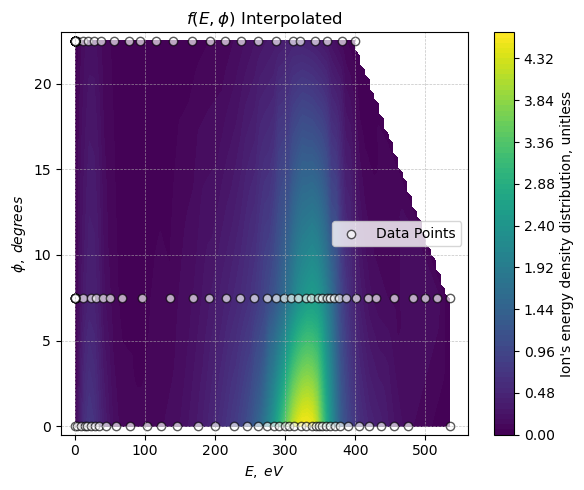

In [43]:
# Plot the interpolated data
plt.figure(figsize=(6, 5))
contour = plt.contourf(E_grid, phi_grid, f_values, levels=lvls, cmap='viridis')
plt.colorbar(contour, label="Ion's energy density distribution, unitless")
plt.scatter(combined_data['E'], combined_data['phi'], c='white', label='Data Points', edgecolors='black', linewidths=1, alpha=0.65)
plt.xlabel(r"$E,\;eV$")
plt.ylabel(r"$\phi,\;degrees$")
plt.title(r"$f(E, \phi)$ Interpolated")
plt.ylim(-0.5, 23)
plt.xlim(-20, combined_data['E'].max()*1.05)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.75)
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir,  f"f(E,  phi).png"), dpi=300)
plt.show()

In [47]:
yth_hth_data = pd.read_csv(data_path + "/y_th_k_th.csv")
yth_hth_data = yth_hth_data.apply(pd.to_numeric, errors='coerce')

yth_hth_data.drop(index=0, inplace=True)
yth_hth_data.fillna(0, inplace=True)
yth_hth_data.head()

,y_th,Unnamed: 1,k_th,Unnamed: 3
1,0.000000,1.000000,0.000000,1.000000
2,0.322581,0.997817,0.230415,0.997817
3,5.299539,1.006550,4.746544,1.002183
4,10.000000,1.032751,9.723502,1.015284
5,15.253456,1.093886,15.990783,1.063319


In [58]:
yth_data = yth_hth_data.iloc[:,  [0,  1]].rename(columns={yth_hth_data.columns[0]:'theta', yth_hth_data.columns[1]:  'yth'})
kth_data = yth_hth_data.iloc[:,  [2,  -1]].rename(columns={yth_hth_data.columns[2]:'theta', yth_hth_data.columns[-1]:  'yth'})

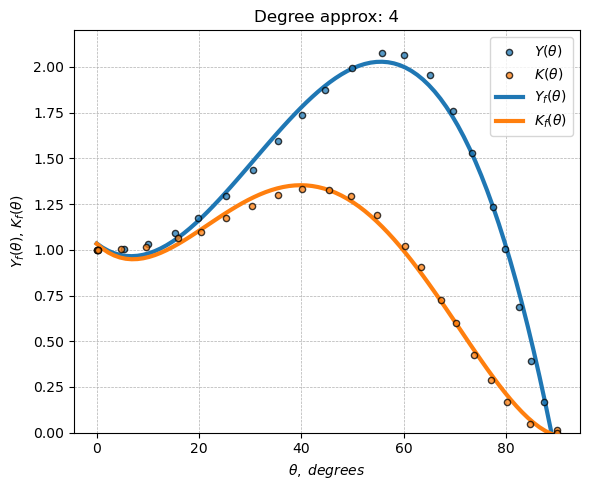

In [72]:
deg = 4
yth_f = np.poly1d(np.polyfit(yth_data['theta'], yth_data['yth'], deg))
kth_f  = np.poly1d(np.polyfit(kth_data['theta'], kth_data['yth'], deg))
theta_lsp = np.linspace(0, 90, n_points)
plt.figure(figsize=(6,  5))
plt.title(f"Degree approx: {deg}")
plt.scatter(yth_data['theta'], yth_data['yth'], s=20, zorder=10, alpha=0.75, edgecolors='black', linewidths=1, label=r'$Y(\theta)$')
plt.scatter(kth_data['theta'], kth_data['yth'], s=20, zorder=10, alpha=0.75, edgecolors='black', linewidths=1, label=r'$K(\theta)$')
plt.plot(theta_lsp, yth_f(theta_lsp), linewidth=3, label=r'$Y_f(\theta)$')
plt.plot(theta_lsp, kth_f(theta_lsp), linewidth=3, label=r'$K_f(\theta)$')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlabel((r"$\theta,\;degrees$"))
plt.ylabel(r"$Y_f(\theta)$, $K_f(\theta)$")
plt.ylim(0, 2.2)
plt.tight_layout()
# plt.savefig(os.path.join(fig_dir,  f"y_th_k_th.png"), dpi=300)
plt.show()

In [73]:
def w(x):
    return -1.158*1e-8*x**4 + 5.007*1e-6*x**3 + 4.065*1e-4*x**2 + 2.212*1e-3*x + 4.158*1e-1

In [83]:
wphi_data  = pd.read_csv(data_path  +  "/wphi.csv")
wphi_data = wphi_data.apply(pd.to_numeric, errors='coerce')

wphi_data.drop(index=0, inplace=True)
wphi_data.fillna(0, inplace=True)
wphi_data = wphi_data.iloc[:,  [0,  1]].rename(columns={wphi_data.columns[0]:'theta', wphi_data.columns[1]:  'wphi'})
wphi_data.head()

,theta,wphi
1,0.000000,0.410000
2,7.741196,0.403703
3,15.223714,0.365944
4,22.700640,0.300115
5,30.101571,0.252788


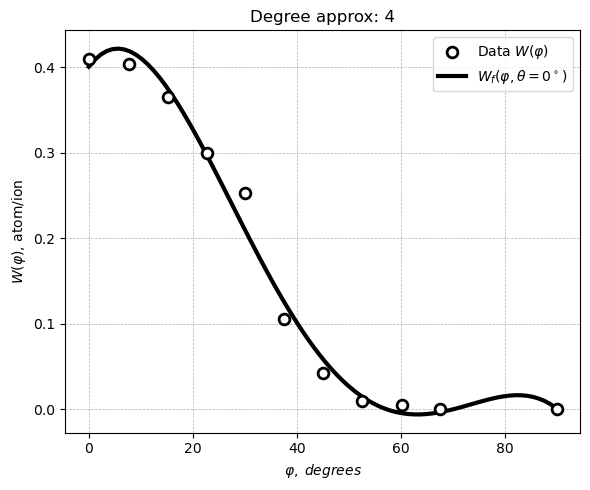

In [91]:
wphi_f = np.poly1d(np.polyfit(wphi_data['theta'], wphi_data['wphi'], deg))
plt.figure(figsize=(6,  5))
plt.scatter(wphi_data['theta'], wphi_data['wphi'], s=60, zorder=10, alpha=1, edgecolors='black', linewidths=2, label=r'Data $W(\varphi)$', c='white')
plt.plot(theta_lsp, wphi_f(theta_lsp), linewidth=3, label=r'$W_f(\varphi, \theta=0^\circ)$', color='black')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xlabel(r"$\varphi,\;degrees$")
plt.ylabel(r"$W(\varphi)$, atom/ion")
plt.title(f"Degree approx: {deg}")
plt.legend()
plt.tight_layout()

plt.show()